In [1]:
# This cell is only required as long as the `facet` package is not public yet

# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is '/Users/hemker konstantin/Documents/repos/Facet/facet'
added `/Users/hemker konstantin/Documents/repos/Facet/pytools/src` to python paths
added `/Users/hemker konstantin/Documents/repos/Facet/facet/src` to python paths
added `/Users/hemker konstantin/Documents/repos/Facet/sklearndf/src` to python paths


# Required Imports

In order to run this notebook, we will import not only the `facet` package, but also a number of other packages useful to solve this task. Overall, we can break down the imports into three categories: 
1. Common packages (pandas, matplotlib, etc.)
2. Required `facet` classes (inpsection, selection, validation, simulation, etc.)
3. Other `gamma` packages which simplify pipelining with `sklearn` and provide some visualization utils

Conventional imports

In [4]:
import pandas as pd
# from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from pathlib import Path

Gamma Facet imports

In [5]:
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

Sklearndf imports

Instead of using the "regular" scikit-learn package, we are using the `sklearndf` (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) wrapper which keeps metadata such as column names when passing the data through the scikit-learn learners.  

In [43]:
# sklearndf
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF


In [7]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

# Background

## Dataset
The dataset used in this example is available on [Kaggle](https://www.kaggle.com/elikplim/maintenance-of-naval-propulsion-plants-data-set) and contains data from experiments carried out by means of a numerical simulator of a naval vessel (Frigate) characterized by a **Gas Turbine propulsion plant**. In this release of the simulator it is also possible to take into account the performance decay over time of the GT components such as GT compressor and turbines.

Each possible degradation state of the plant can be characterized by three parameters: 
- Ship speed (linear function of the lever position)
- Compressor degradation coefficient kMc
- Turbine degradation coefficient

The degradation coefficients typically vary between [1; 0.95] for compressor and [1; 0.975] for the gas turbine. 

## Features
One observation in this dataset represents the current decay states of the compresor and the gas turbine along with a number of sensor readings of the shipping vessels at that point in time. 


## Learning Problem
For this learning problem, we have three key objectives: 
1. Predict the decay state of the gas turbine as accurately as possible
2. Understand which parameters drive the decay state of the turbine
3. Analyze how these drivers interact with each other and the target


While we can solve questions 1 and parts of question 2 with commonly used machine learning packages, `facet` will enable us to make better inferences about the way some of the features share or complement information and help us to figure out the optimal settings of the vessel to minimize the equipment degradation at a variety of ship speeds.


# Loading data and EDA

You can find the raw data used in this notebook both on the [UCI Machine Learning Data Archive](http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants) as well as in the `sphinx/source/tutorials/naval_propulsion/` folder in this repository. 

We start off by loading in the data, assigning human-readable labels to it as well as setting the turbine decay state coefficient as the `TARGET`. 

In [30]:
data_root = Path("sphinx/source/tutorial/")
df = pd.read_csv(data_root.joinpath("naval_propulsion/data.txt"), delim_whitespace=True)

df.columns = ['Lever Position', 
              'Ship Speed', 
              'Turbine Shaft Torque (kN m)', 
              'Turbine Rate of Revolutions (rpm)', 
              'Generator Rate of Revolutions (rpm)', 
              'Starboard Propeller Torque (kN)', 
              'Port Propeller Torque (kN)', 
              'HP Turbine exit temp (C)', 
              'GT Compressor inlet air temp (C)', 
              'GT Compressor outlet air temp (C)', 
              'Turbine exit pressure (bar)', 
              'Compressor inlet air pressure (bar)', 
              'Compressor outlet air pressure (bar)', 
              'Turbine exhaust gas pressure (bar)', 
              'Turbine injection control', 
              'Fuel flow', 
              'GT Compressor decay state coeff',  
              'GT Turbine decay state coeff']

TARGET = "GT Turbine decay state coeff"

For easier management of the data we are using in this example, we are using `facet`'s `Sample` class, which allows to do a number of things: 
- Quickly access the target vs. features
- Pass the sample into `sklearndf` data pipelines
- Assign weight vectors to the sample which are propagated down to the learners (given that they support sample weighting)

In [31]:
# need to drop the other target
df.drop("GT Compressor decay state coeff", inplace=True, axis=1)
sample = Sample(observations=df, target=TARGET)

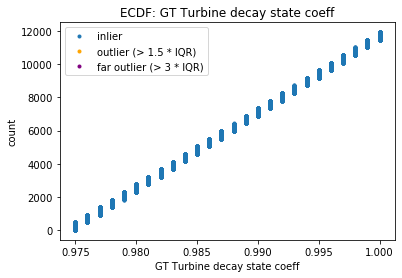

In [32]:
ECDFDrawer().draw(sample.target)

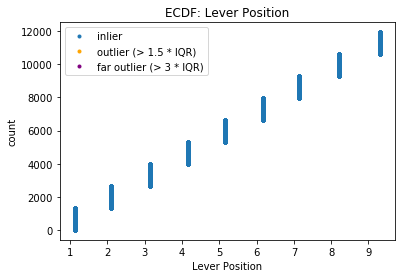

In [33]:
ECDFDrawer().draw(sample.features["Lever Position"])

# Building a simple pipeline

Define the Boruta Feature selection

In [34]:
boruta = BorutaDF(
    estimator = RandomForestRegressorDF(max_depth=5, random_state=42, n_jobs=3), 
    n_estimators="auto",  
    random_state=42, 
    verbose=1
)

In [35]:
preprocessing_pipeline = PipelineDF(
    steps = [
        ("impute", SimpleImputerDF()),
        ("feature selection", boruta)
    ]

)

In [36]:
preprocessing_pipeline.fit(X=sample.features, y=sample.target)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

PipelineDF(memory=None,
           steps=[('impute',
                   SimpleImputerDF(add_indicator=False, copy=True,
                                   fill_value=None, missing_values=nan,
                                   strategy='mean')),
                  ('feature selection',
                   BorutaDF(estimator=RandomForestRegressor(max_depth=5,
                                                            n_estimators=89,
                                                            n_jobs=3,
                                                            random_state=<mtrand.RandomState object at 0x7fe208bf6cd0>),
                            n_estimators='auto',
                            random_state=<mtrand.RandomState object at 0x7fe208bf6cd0>,
                            verbose=1))],
           verbose=False)

In [37]:
print(f"Selected features: {', '.join(boruta.features_out)}")

Selected features: Turbine Shaft Torque (kN m), Turbine Rate of Revolutions (rpm), Generator Rate of Revolutions (rpm), HP Turbine exit temp (C), GT Compressor outlet air temp (C), Compressor outlet air pressure (bar), Turbine exhaust gas pressure (bar), Turbine injection control, Fuel flow


We can see that Boruta accepted 9 features and rejected 6. We now select the relevant features from the feature selection.

In [38]:
sample_selected = sample.keep(boruta.features_out)

# Cross validation

We will use a simple Bootstrap for the time series analysis here. Note that if we were given a time series dataset here (i.e. if we had timestamps of the GT readings) we could use a stationary bootstrap here using `StationaryBootstrapCV`)

In [39]:
cv = BootstrapCV(n_splits=10, random_state=42)

# Regressor Pipeline

In [40]:
rf_pipeline = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(n_estimators=500, random_state=42),
)

lgbm_pipeline = RegressorPipelineDF(
    regressor=LGBMRegressorDF(random_state=42),
)

In [41]:
grid = [
    LearnerGrid(
        pipeline=rf_pipeline, 
        learner_parameters={ 
            "min_samples_leaf": [8, 11, 15]
        } 
        ),
    LearnerGrid(
        pipeline=lgbm_pipeline, 
        learner_parameters={ 
            "min_data_in_leaf": [8, 11, 15]
        }
    )
    
]

# Model Ranking

In [42]:
ranker = LearnerRanker(
    grids=grid, cv=cv, n_jobs=-3
).fit(sample=sample_selected)

In [ ]:
ranker.best_model

In [ ]:
ranker.summary_report()

In [ ]:
ranker.best_model_crossfit

# Model inspection

In [ ]:
inspector = RegressorInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit)

#### Feature redundancy

In [ ]:
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="text").draw(redundancy_matrix, title="Turbine Decay")

For reference, we can see that this uncovers very high redundancy which would not have been visible in a simple correlation matrix.

In [ ]:
sns.heatmap(sample_selected.features.corr())

In [ ]:
redundant_features = ["Fuel flow", "Turbine exhaust gas pressure"]

In [ ]:
redundancy = inspector.feature_redundancy_linkage()

DendrogramDrawer().draw(data=redundancy, title="Turbine Decay")

In [ ]:
synergy_matrix = inspector.feature_synergy_matrix()

In [ ]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Turbine Decay")

Removing the redundant features and retraining the pipeline

In [ ]:
sample_revised = sample_selected.drop(redundant_features)

In [ ]:
# Run the training pipeline again
ranker_revised = LearnerRanker( 
    grids=grid, cv=cv, n_jobs=-3
).fit(sample=sample_revised)

In [ ]:
ranker_revised.best_model

In [ ]:
ranker_revised.summary_report()

# Simulation

From the synergy matrix, we can see that the Compressor outlet temperature has the highest synergy with most other features. Therefore, we would want to see how the target behaves if we simulate this feature such that each state had a constant outlet compressor temperature. 

First of all, let's see if this is also confirmed by the SHAP feature importances. 

In [ ]:
abs_shap_values = inspector.shap_values().abs().sum(axis=0).reset_index().rename({0: "Sum of abs SHAP values"}, axis=1)

In [ ]:
abs_shap_values.sort_values(by="Sum of abs SHAP values", ascending=False)

We can see that the strong synergies with all other features of the Compressor outlet air temperature is also visible in the aboslute SHAP values. 

In [ ]:
sample.features.columns

In [ ]:
SIM_FEATURE = 'GT Compressor outlet air temp [C]'

In [ ]:
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)

In [ ]:
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = ContinuousRangePartitioner())

In [ ]:
ECDFDrawer().draw(
    sample.features[SIM_FEATURE]
)

In [ ]:
SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)

# Next Steps

# Sources

The dataset used in this example was provided by: 

[1] A. Coraddu, L. Oneto, A. Ghio, S. Savio, D. Anguita, M. Figari, Machine Learning Approaches for Improving Condition?Based Maintenance of Naval Propulsion Plants, Journal of Engineering for the Maritime Environment, 2014, DOI: 10.1177/1475090214540874, (In Press)